In [1]:
include("../sensor.jl")
include("../doa/dbf_freeform.jl")

include("../utils/preprocess.jl")

sensors Loaded: (8,)
sensors1 Loaded: (25,)
sensors2 Loaded: (20,)
sensors_underwater loaded: (40,)


In [271]:
#=
Step 0: Open recording or generate signal
=#

# To Generate Signal:
include("../signal_generator/tone.jl")

freq = 50;          # Frequency of Tone (in Hz)
amp = 1;            # Amplitude of Tone
duration = 10;       # Duration of Tone (in seconds)
sample_rate = 32000.0;
tone_sig, n = tone(duration, amp, freq, sample_rate);

In [272]:
include("../signal_generator/generate_sig.jl")
az_gt = -90.0;        # Ground Truth Azimuth Angle (in degrees)
az_gt2 = 120.0;
c0 = 1500;          # Speed of Medium (in m/s)

sig1, sample_rate = simulate_sensor_signal(tone_sig, sample_rate, sensors, az_gt, c0);
sig2, sample_rate = simulate_sensor_signal(tone_sig, sample_rate, sensors, az_gt2, c0); 
new_sig = sig1 + sig2;

Start Simulating Signal
Signal has size: (320000, 1)
Using FFT for Delaying


  0.132796 seconds (286 allocations: 126.970 MiB)
Now Generated Signal has size: (320000, 8)
Start Simulating Signal
Signal has size: (320000, 1)
Using FFT for Delaying


  0.134778 seconds (286 allocations: 126.970 MiB)
Now Generated Signal has size: (320000, 8)


In [273]:
#= 
Step 1: Pre-process Signal by selecting 
        Frequency of Interest at each channel
        (FFT instead of STFT)
=#
function filter_freq_per_ch(new_sig, freq_interest)
    # freq_interest = freq; # (Hz)
        new_S = []
        NFFT = size(new_sig, 1);
        frequencies = sample_rate/NFFT*(0:(NFFT-1));
        (_, freq_idx) = findmin( abs.(frequencies .- freq_interest) );
    
        for signal in eachcol(new_sig)
            S_interest = fft(signal);
            S_interest = S_interest[freq_idx];
            push!(new_S, S_interest);
        end
        return new_S
    end
    
    new_S = filter_freq_per_ch(new_sig, freq);
    new_S1 = filter_freq_per_ch(sig1, freq);
    new_S2 = filter_freq_per_ch(sig2, freq);

    Rx = (1 ./ 1) .* new_S * new_S';
    Rx1 = (1 ./ 1) .* new_S1 * new_S1';
    Rx2 = (1 ./ 1) .* new_S2 * new_S2';

In [142]:
d(ω, az, sensor::Vector, c0=343) = exp(1im * (ω * sensor[1] / c0) * cos(az - sensor[2]))

d (generic function with 2 methods)

In [254]:
# Construct UCA Null-Constraint & Symmetrical Formulation
polar_sensor = sensors_in_polar(sensors);
az_steer = deg2rad(30.0); # radians
null1 = deg2rad(120);#deg2rad(51);#2*π - 2//7 * π;
null2 = deg2rad(103);#2*π - 4//7 * π;
null3 = deg2rad(154);#2*π - 6//7 * π;
steering_d(freq, az, sensors::Vector, c0=343) = d.(2*π*freq, az, sensors, c0);

constraint_angles = [az_steer, null1, null2, null3];
constraint_angles = [az_steer, null1];
constraint_matrix = [];
const_vec = [];
for (idx, angle) in enumerate(constraint_angles)
    println("Now constraining angle : $(rad2deg(angle))°, $(angle) radians")
    if idx == 1
        steer_vec = steering_d(freq, angle, polar_sensor, c0);
        push!(constraint_matrix, steer_vec')
        push!(const_vec, 1)
        continue
    end
    println("Now constraining angle : $(rad2deg(az_steer + angle))°, $(az_steer + angle) radians")
    steer_vec = steering_d(freq, az_steer + angle, polar_sensor, c0);
    push!(constraint_matrix, steer_vec');
    push!(const_vec, 0);
    println("Now constraining angle : $(rad2deg(az_steer - angle))°, $(az_steer - angle) radians")
    steer_vec = steering_d(freq, az_steer - angle, polar_sensor, c0);
    push!(constraint_matrix, steer_vec');
    push!(const_vec, 0);
end

new_mat = reduce(vcat, constraint_matrix)
h = new_mat' * inv(new_mat * new_mat') * const_vec

Now constraining angle : 29.999999999999996°, 0.5235987755982988 radians
Now constraining angle : 119.99999999999999°, 2.0943951023931953 radians
Now constraining angle : 149.99999999999997°, 2.617993877991494 radians
Now constraining angle : -90.0°, -1.5707963267948966 radians


8-element Vector{Any}:
   0.08266204134190724 - 0.09922894080123448im
   0.03129884986210185 - 0.6031405233256067im
 0.0017610684454931747 - 0.7537079696024992im
  0.052977886775323224 - 0.46280752422361504im
   0.08266204134190724 + 0.09922894080123451im
   0.03129884986210185 + 0.6031405233256065im
 0.0017610684454931747 + 0.7537079696024993im
  0.052977886775323224 + 0.46280752422361493im

In [249]:
h = new_mat' * inv(new_mat * new_mat') * const_vec

8-element Vector{Any}:
   0.08266204134190724 - 0.09922894080123448im
   0.03129884986210185 - 0.6031405233256067im
 0.0017610684454931747 - 0.7537079696024992im
  0.052977886775323224 - 0.46280752422361504im
   0.08266204134190724 + 0.09922894080123451im
   0.03129884986210185 + 0.6031405233256065im
 0.0017610684454931747 + 0.7537079696024993im
  0.052977886775323224 + 0.46280752422361493im

[-50.2042248395788, -87.02940722695027, -89.86612639137596, -83.46973798629683, 50.204224839578806, 87.02940722695027, 89.86612639137596, 83.46973798629683]


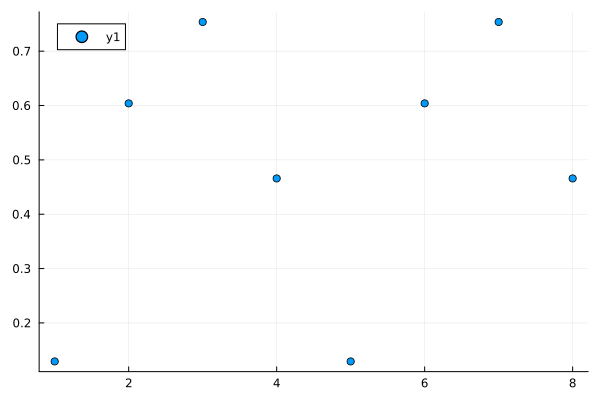

In [253]:
println(rad2deg.(angle.(h)))
scatter(abs.(h))

In [240]:
constraint_matrix[1] * h

0.9999999994882778 + 3.950617610826157e-12im

In [241]:
az_list = -180:180;
az_list_rad = deg2rad.(az_list);
beampattern = [];

for az in az_list_rad
    d_steer = steering_d(freq, az, polar_sensor, c0);
    push!(beampattern, d_steer' * h);
end


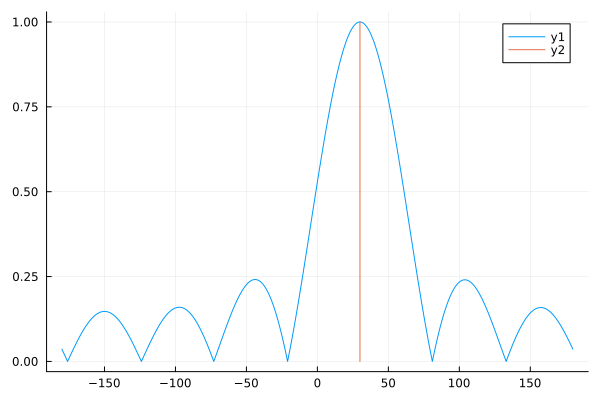

In [242]:
plot(az_list, abs.(beampattern))
plot!([rad2deg(az_steer), rad2deg(az_steer)], [0,1])

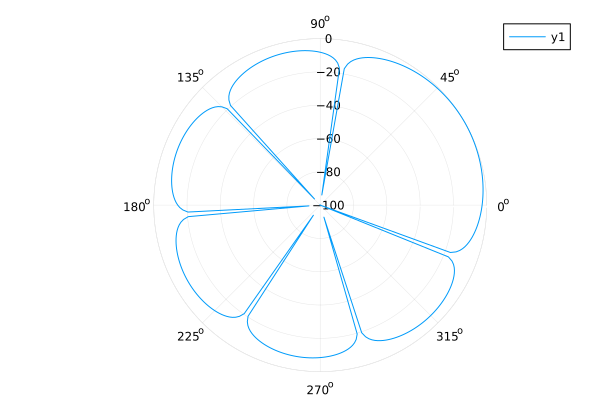

In [244]:
using Plots
plot(az_list_rad, pow2db.(abs.(beampattern)), proj=:polar)
ylims!(-100, 0)

In [132]:
testfunc(x) = 1/7 + 2/7 * cos(x) + 2/7 * cos(2*x) + 2/7 * cos(3*x)
testfunc2(x) = 1/5 + 2/5 * cos(x) + 3/5 * cos(2*x)
testfunc(2*π - 6//7 * π)
testfunc2(deg2rad(144))
# testfunc( deg2rad( 154) )

0.06180339887498937

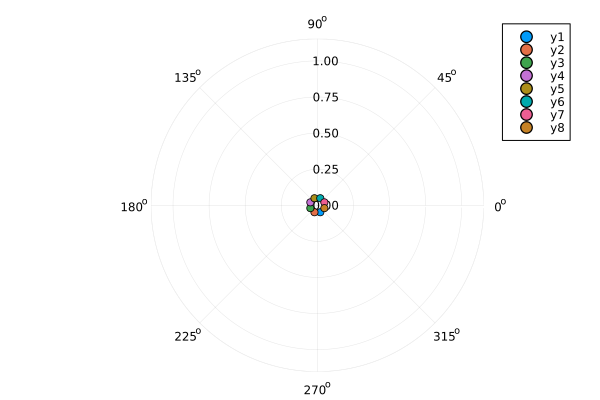

In [92]:
p = plot();
for sensor in polar_sensor
    p = scatter!([sensor[2]], [sensor[1]], proj=:polar)
end
display(p)

In [298]:
# Construct UCA Null-Constraint & Symmetrical Formulation
polar_sensor = sensors_in_polar(sensors);
P = [];
for az in az_list
    az_steer = deg2rad(az); # radians
    null1 = deg2rad(51);#2*π - 2//7 * π;
    null2 = deg2rad(103);#2*π - 4//7 * π;
    null3 = deg2rad(154);#2*π - 6//7 * π;
    steering_d(freq, az, sensors::Vector, c0=343) = d.(2*π*freq, az, sensors, c0);

    constraint_angles = [az_steer, null1, null2, null3];
    # constraint_angles = [az_steer, null1];
    constraint_matrix = [];
    const_vec = [];
    for (idx, angle) in enumerate(constraint_angles)
        # println("Now constraining angle : $(rad2deg(angle))°, $(angle) radians")
        if idx == 1
            steer_vec = steering_d(freq, angle, polar_sensor, c0);
            push!(constraint_matrix, steer_vec')
            push!(const_vec, 1)
            continue
        end
        # println("Now constraining angle : $(rad2deg(az_steer + angle))°, $(az_steer + angle) radians")
        steer_vec = steering_d(freq, az_steer + angle, polar_sensor, c0);
        push!(constraint_matrix, steer_vec');
        push!(const_vec, 0);
        # println("Now constraining angle : $(rad2deg(az_steer - angle))°, $(az_steer - angle) radians")
        steer_vec = steering_d(freq, az_steer - angle, polar_sensor, c0);
        push!(constraint_matrix, steer_vec');
        push!(const_vec, 0);
    end

    new_mat = reduce(vcat, constraint_matrix)
    h = new_mat' * inv(new_mat * new_mat') * const_vec
    push!(P, h' * Rx * h)
end

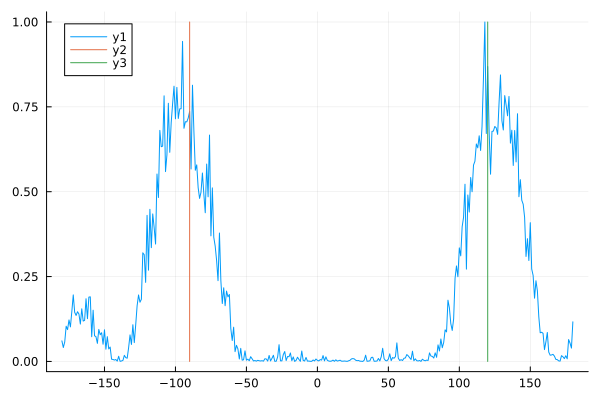

In [299]:
plot(az_list, abs.(P) ./ maximum(abs.(P)))
plot!([az_gt, az_gt], [0,1])
plot!([az_gt2, az_gt2], [0,1])

In [300]:
using WAV
# new_sig, sample_rate = wavread("./signal_generator/270deg_1kHz_tone_sr32kHz.wav");
# new_sig, sample_rate = wavread("./signal_generator/1000hz_circle.wav");
new_sig, sample_rate = wavread("../signal_generator/50hz_circle.wav");

In [301]:
freq = 50;            # Frequency of Interest (in Hz)
c0 = 343;             # Speed of Medium (in m/s)
NFFT = 2^8; #2^11;
noverlap = Int(NFFT * (3 // 4));

In [317]:
# Construct UCA Null-Constraint & Symmetrical Formulation
function third_order_dbf_uca(Rx, sensors, freq, c0)
    polar_sensor = sensors_in_polar(sensors);
    P = [];
    az_list = -180:180;
    h_filters = [];
    for az in az_list
        az_steer = deg2rad(az); # radians
        null1 = deg2rad(51);#2*π - 2//7 * π;
        null2 = deg2rad(103);#2*π - 4//7 * π;
        null3 = deg2rad(154);#2*π - 6//7 * π;
        steering_d(freq, az, sensors::Vector, c0=343) = d.(2*π*freq, az, sensors, c0);

        constraint_angles = [az_steer, null1, null2, null3];
        constraint_matrix = [];
        const_vec = [];
        for (idx, angle) in enumerate(constraint_angles)
            # println("Now constraining angle : $(rad2deg(angle))°, $(angle) radians")
            if idx == 1
                steer_vec = steering_d(freq, angle, polar_sensor, c0);
                push!(constraint_matrix, steer_vec')
                push!(const_vec, 1)
                continue
            end
            # println("Now constraining angle : $(rad2deg(az_steer + angle))°, $(az_steer + angle) radians")
            steer_vec = steering_d(freq, az_steer + angle, polar_sensor, c0);
            push!(constraint_matrix, steer_vec');
            push!(const_vec, 0);
            # println("Now constraining angle : $(rad2deg(az_steer - angle))°, $(az_steer - angle) radians")
            steer_vec = steering_d(freq, az_steer - angle, polar_sensor, c0);
            push!(constraint_matrix, steer_vec');
            push!(const_vec, 0);
        end

        new_mat = reduce(vcat, constraint_matrix)
        h = new_mat' * inv(new_mat * new_mat') * const_vec
        push!(P, h' * Rx * h)
        push!(h_filters, h)
    end

    return abs.(P), az_list, h_filters
end

third_order_dbf_uca (generic function with 1 method)

In [326]:
function first_order_dbf_uca(Rx, sensors, freq, c0)
    polar_sensor = sensors_in_polar(sensors);
    P = [];
    az_list = -180:180;
    h_filters = [];
    for az in az_list
        az_steer = deg2rad(az); # radians
        null1 = deg2rad(180);
        steering_d(freq, az, sensors::Vector, c0=343) = d.(2*π*freq, az, sensors, c0);

        constraint_angles = [az_steer, null1];
        constraint_matrix = [];
        const_vec = [];
        for (idx, angle) in enumerate(constraint_angles)
            # println("Now constraining angle : $(rad2deg(angle))°, $(angle) radians")
            if idx == 1
                steer_vec = steering_d(freq, angle, polar_sensor, c0);
                push!(constraint_matrix, steer_vec')
                push!(const_vec, 1)
                continue
            end
            # println("Now constraining angle : $(rad2deg(az_steer + angle))°, $(az_steer + angle) radians")
            steer_vec = steering_d(freq, az_steer + angle, polar_sensor, c0);
            push!(constraint_matrix, steer_vec');
            push!(const_vec, 0);
            # println("Now constraining angle : $(rad2deg(az_steer - angle))°, $(az_steer - angle) radians")
            steer_vec = steering_d(freq, az_steer - angle, polar_sensor, c0);
            push!(constraint_matrix, steer_vec');
            push!(const_vec, 0);
        end

        new_mat = reduce(vcat, constraint_matrix)
        h = new_mat' * pinv(new_mat * new_mat') * const_vec
        push!(P, h' * Rx * h)
        push!(h_filters, h)
    end

    return abs.(P), az_list, h_filters
end

first_order_dbf_uca (generic function with 1 method)

In [327]:
include("../doa/cbf.jl")
include("../doa/dbf_freeform.jl")

function filter_freq_per_ch(new_sig)
    new_S = []
    for sig in eachcol(new_sig)
        S_interest = choose_freq(sig, freq, sample_rate, NFFT, noverlap);
        push!(new_S, S_interest);
    end
    # test_sig = Matrix{}(undef, size(new_sig, 2)) 
    new_S = mapreduce(permutedims, vcat, new_S);
    return new_S
end

new_S = filter_freq_per_ch(new_sig);

In [328]:
using Statistics
#=
Prepate for TDoA
=#
corr_samples = 64;
max_snapshots = div(size(new_S, 2), corr_samples);
t_doa = 1:max_snapshots;
az = [];
P_dbfs_uca = [];
dbf_uca_filters = [];
doas_dbfs_uca = [];

for t in t_doa
    start = (t-1) * corr_samples + 1;
    end_t = t * corr_samples;
    Rx = cov(new_S[:, start:end_t], dims=2);

    P_dbf_uca, az_list, dbf_uca_filter = first_order_dbf_uca(Rx, sensors, freq, c0);
    __, az_dbf_uca = predict_az(P_dbf_uca, az_list);
    push!(doas_dbfs_uca, az_dbf_uca)
    push!(P_dbfs_uca, P_dbf_uca)

    if t == 1
        append!(az, az_list)
        println("dbf_filter: $(dbf_uca_filter)")
        push!(dbf_uca_filters, dbf_uca_filter)
    end
end

P_dbfs_uca = mapreduce(permutedims, vcat, P_dbfs_uca);
P_dbfs_uca = P_dbfs_uca';

dbf_filter: Any[Any[0.0625616957190438 - 0.9954142471184828im, 0.0625616957190438 + 0.9954142471184836im, 0.06251056146641787 + 2.402411068582304im, 0.06251056146641787 + 2.402411068582304im, 0.0625616957190438 + 0.9954142471184827im, 0.0625616957190438 - 0.9954142471184828im, 0.06251056146641787 - 2.4024110685823046im, 0.06251056146641787 - 2.402411068582304im], Any[0.06256257258591802 - 0.9533278140354634im, 0.06256078770255868 + 1.0371969034399502im, 0.0625096848425244 + 2.4194015072293484im, 0.06251146923990802 + 2.384689065939501im, 0.06256257258591802 + 0.953327814035464im, 0.06256078770255868 - 1.0371969034399504im, 0.0625096848425244 - 2.419401507229348im, 0.06251146923990802 - 2.3846890659395013im], Any[0.06256341723440606 - 0.9109504371156787im, 0.06255984964318806 + 1.078663044153931im, 0.06250884043581983 + 2.435655235619478im, 0.06251240705746319 + 2.366240867761885im, 0.06256341723440606 + 0.9109504371156785im, 0.06255984964318806 - 1.0786630441539304im, 0.062508840435819

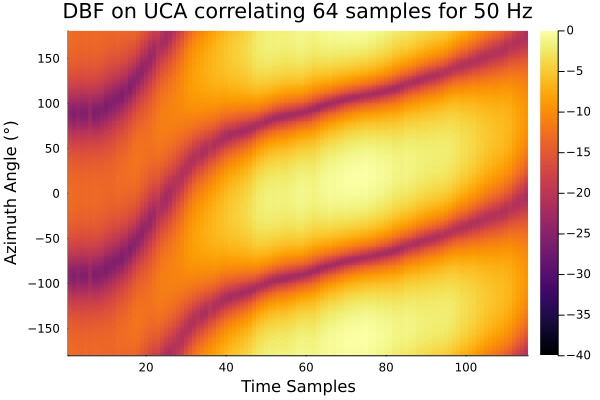

(361, 115)
  0.002002 seconds (665 allocations: 432.258 KiB)


In [329]:
using Plots
using DSP.Util: pow2db
P_dbf_uca_db = pow2db.(P_dbfs_uca);
P_dbf_uca_db .-= maximum(P_dbf_uca_db);
println(size(P_dbf_uca_db))
@time p = plot(t_doa, az, P_dbf_uca_db, st=:heatmap,
     clims=(-40.0, 0.0),
     xlabel="Time Samples",
     ylabel="Azimuth Angle (°)",
     title="DBF on UCA correlating $(corr_samples) samples for $(freq) Hz", rasterized = true)
display(p)

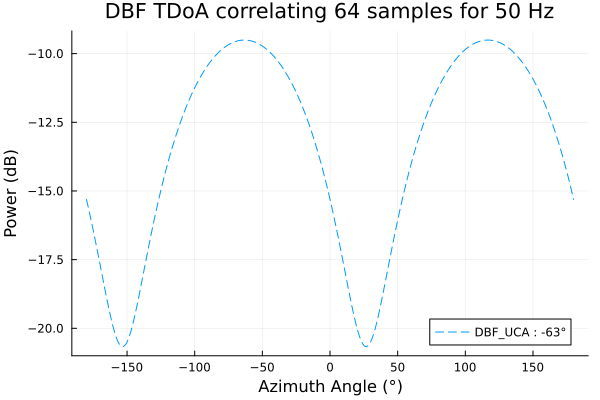

In [330]:
sam = 30;
p3 = plot(az, P_dbf_uca_db[:,sam], label="DBF_UCA : $(doas_dbfs_uca[sam])°",
    linestyle=:dash);
xlabel!("Azimuth Angle (°)");
ylabel!("Power (dB)");
title!("DBF TDoA correlating $(corr_samples) samples for $(freq) Hz")
display(p3)